# Conditional GAN for timeseries simulations

The core idea is to use **conditional shifts** to generate counterfactual macroeconomic indicator variable timeseries based on changes in one key indicator variable - the conditioning variable $c$. For example, to answer the question whether or not the effect of a certain central bank policy measured through variables $\textbf{x} = {x_1, x_2, ..., x_m}, \textbf{x} \subset X \land y \notin \textbf{x}$ (i.e., $\textbf{x} = X \setminus y$) would be different when the price of a certain commodity $y \in X$ would have been triple that found in the real data (shifting $y$ to $c$), one needs to be able to model the effect of changes in variable $y$ on all other variables $\textbf{x}$ in the dataset $X$.

To formalize, we need to model both the joint probability

$$ P(y_t,\textbf{x}_t) = P(X_{t-n:t-1}|y_{t-n:t-1},\textbf{x}_{t-n:t-1}), y \in X, \textbf{x} \subset X$$

of the conditioning variable $y$ and the conditioned variables $\textbf{x} \subseteq X$ at time $t$ conditional on previous timesteps ${t-n, ..., t-1}$, **and** the conditional probability of $\textbf{x}$ given $y$ at time $t$,

$$P(\textbf{x}_t|y_t)$$

From a Bayesian point of view, it makes sense to take the distribution in the real data as the prior. This means that the CGAN needs to
1. Approximate the $n$ historical autoregressive priors for all variables $p(X_t|X_{t-n:t-1})$ at $X_t$ given $X_{t-n}, ..., X_{t-1}$.
2. Infer the posterior distribution $p(X_{t-n:t-1},\alpha,\beta|X_t) \propto p(X_t|X_{t-n:t-1},\alpha,\beta)p(X_t|X_{t-n:t-1})$, where $\alpha$ maps contemporary relationships between variables at time $t$ and $\beta$ models the autoregressive relationship over time for all variables, mapping $X_{t-n:t-1}$ on to $X_t$.
3. Use the inferred posterior of the variables $\textbf{x}$ to generate $Y = c,P(\textbf{x}|c,s,\alpha,\beta)$, where $c$ is the conditioned form of $y$ shifted to simulate some explicitly programmed counterfactual scenario $s$, and $P(\textbf{x}|c,s)$ are the values of $\textbf{x}$ mapped onto this counterfactual scenario $s$. 

Given that a scenario $s$ can also be modeled as a regime, it might be good to look into RL research on the topic of policy switches in model-based RL.

##### Training

Translating the Bayesian model to a GAN framework,
* The generator generates datapoints conditional both on $\textbf{A}$ autoregressive previous timesteps ${t-n, ..., t-1}$ and $\textbf{B}$ lateral relationships between variables (longitudinal and contemporary effects), ignoring $\textbf{C}$ the conditional variable $c$ during training.
* The discriminator is used to train the generator to model $\textbf{A}$ and $\textbf{B}$ as realistically as possible.
* During inference $c$ is shifted to simulate the counterfactual condition $\textbf{C}$, letting the generator model the effect of $c$ on the $x \in X$ variables of interest.

##### Generator architecture

It might be best to model $\alpha$ and $\beta$ with the same parameter set, as is current best practice in sequence modeling. One obvious candidate architecture that springs to mind are transformer networks, for example the [universal transformer](https://arxiv.org/abs/1807.03819) architecture. They have been shown to work well for music generation by [the Google Magenta team](https://magenta.tensorflow.org/music-transformer), and can be used to model both the contemporary and autoregressive connections in the data.

A key concern is that there is not a lot of training data to begin with.

*// TODO: investigate possibilities for pre-training the model using other datasets, for example in a multitask setup.*

##### Discriminator architecture

The loss function is the main problem here. 

*// TODO: investigate loss functions for time series generation and simulation models.*

##### Simulation

*// TODO: implement inference layer that allows for the combination of manually conditioned timeseries data $c$ and generated data $x$.*


In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow import keras

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:20,.4f}'.format

In [3]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")

#### Load and prepare the data

In [4]:
country = 'France'

In [5]:
features_df = pd.read_csv('features/m_one/%s_features.csv' % country, sep=';', header=0)
labels_df = pd.read_csv('features/m_one/labels_interpolated.csv', sep=';', header=0)

In [6]:
combined_df = pd.concat([features_df, labels_df.drop(columns=['date'])], axis=1)

In [7]:
combined_df.head()

,date,bank capital to assets ratio,bank nonperforming loans,cereal yield,energy imports,food exports,high-tech exports,inflation,lending interest rate,life expectancy,...,France,Ghana,India,Indonesia,Japan,Netherlands,Senegal,Singapore,Switzerland,United States
0,1960-01-01,0.0000,0.0000,0.0000,0.4282,0.0000,0.0000,0.0000,0.0387,69.8683,...,0.0414,0.0000,0.0178,0.3959,0.0357,0.0232,0.0000,0.0000,0.0144,0.0146
1,1960-02-01,0.0000,0.0000,0.0000,0.4313,0.0000,0.0000,0.0000,0.0384,69.8890,...,0.0399,0.0000,0.0178,0.3743,0.0372,0.0224,0.0000,0.0003,0.0147,0.0143
2,1960-03-01,0.0000,0.0000,0.0000,0.4344,0.0000,0.0000,0.0000,0.0381,69.9098,...,0.0385,0.0000,0.0178,0.3527,0.0387,0.0215,0.0000,0.0007,0.0151,0.0139
3,1960-04-01,0.0000,0.0000,0.0000,0.4375,0.0000,0.0000,0.0000,0.0378,69.9305,...,0.0371,0.0000,0.0178,0.3312,0.0402,0.0207,0.0000,0.0010,0.0154,0.0136
4,1960-05-01,0.0000,0.0000,0.0000,0.4406,0.0000,0.0000,0.0000,0.0375,69.9512,...,0.0356,0.0000,0.0177,0.3096,0.0417,0.0199,0.0000,0.0013,0.0157,0.0133


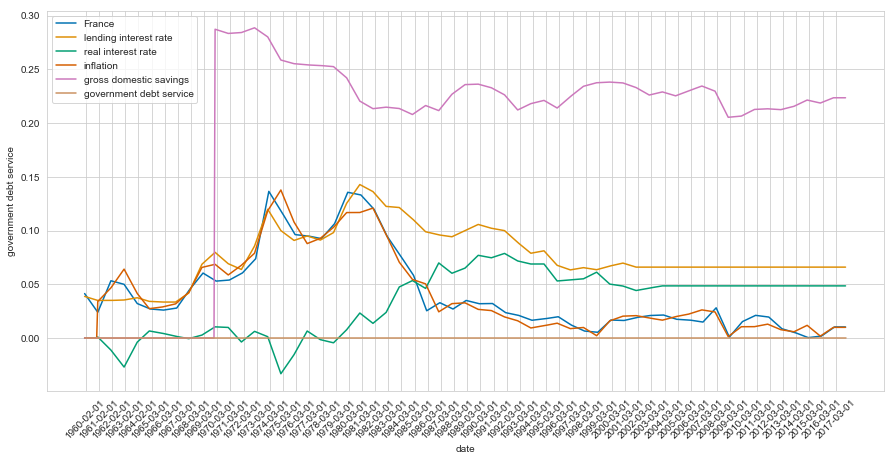

In [8]:
fig, ax = plt.subplots(figsize=(15,7))
[sns.lineplot(x='date', y=c, markers=True, ax=ax, label=c, data=combined_df) for c in list([country, 'lending interest rate', 'real interest rate', 'inflation', 'gross domestic savings', 'government debt service'])]

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 12 == 1:
        xticks[i].set_visible(True)
    else:
        xticks[i].set_visible(False)

ax.set_xticklabels(combined_df['date'], rotation=45);

In [9]:
combined_df.columns

Index(['date', 'bank capital to assets ratio', 'bank nonperforming loans',
       'cereal yield', 'energy imports', 'food exports', 'high-tech exports',
       'inflation', 'lending interest rate', 'life expectancy',
       'population density', 'real interest rate', 'broad money',
       'exports of goods and services', 'gross domestic savings',
       'high-tech value added', 'household consumption expenditure',
       'imports of goods and services', 'listed companies',
       'manufacturing value added', 'r and d spend', 'services trade', 'trade',
       'government debt service', 'government interest payments external debt',
       'government tax revenue', 'birth deaths', 'broadband subscriptions',
       'electricity access', 'co2 emissions', 'electricity consumption',
       'mobile subscriptions', 'newborns', 'overweight', 'rural population',
       'urban population', 'Brazil', 'China', 'Colombia', 'France', 'Ghana',
       'India', 'Indonesia', 'Japan', 'Netherlands', 'Seneg

In [10]:
base_feature_df = combined_df[['date', 'bank capital to assets ratio', 'bank nonperforming loans', 'cereal yield',
                               'energy imports', 'food exports', 'high-tech exports', 'inflation',
                               'lending interest rate', 'life expectancy', 'population density', 'real interest rate',
                               'broad money', 'exports of goods and services', 'gross domestic savings',
                               'high-tech value added', 'household consumption expenditure',
                               'imports of goods and services', 'listed companies', 'manufacturing value added',
                               'r and d spend', 'services trade', 'trade', 'government debt service',
                               'government interest payments external debt', 'government tax revenue', 'birth deaths',
                               'broadband subscriptions', 'electricity access', 'co2 emissions',
                               'electricity consumption', 'mobile subscriptions', 'newborns', 'overweight',
                               'rural population', 'urban population', country]]

In [11]:
base_feature_df['label'] = base_feature_df[country].shift(periods=1)
base_df = base_feature_df.drop(country, axis=1).fillna(0.00);
base_df.set_index('date');

In [12]:
num_obs = len(base_df)
num_cols = len(base_df.columns)
num_features = len(base_df.columns) - 1

In [13]:
gan_df = base_df[['label']]
gan_df.shape

(696, 1)

In [14]:
gan_cols = gan_df.shape[1]

## Simple conditional generative adverserial network

In [15]:
from keras.models import Sequential, Model
from keras.layers import Input
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [16]:
gan_params = {
   'num_epochs': 2000,
   'save_interval': 100,
   'sequence_length': 3,
   'num_variables': gan_cols,
   'batch_size': 32,
   'lr': 0.001 
}

In [17]:
generator_params = {
   'dropout': 0.4,
   'rnn_units': 256,
   'lr': 0.001
}

In [18]:
discriminator_params = {
   'bi_lstm_units': 64,
   'dropout_rate': 0.1,
   'lr': 0.001
}

In [19]:
gan_features = []
gan_labels = []

for i in range(int(num_obs / gan_params['sequence_length'])):
    gan_labels_df = gan_df['label']
    gan_labels.append(gan_labels_df[i:(i+gan_params['sequence_length'])].values[-1:])
    gan_features.append(gan_df[i:(i+gan_params['sequence_length'])].values)

In [20]:
real = np.asarray(gan_features)
real = real.reshape((real.shape[0], gan_params['sequence_length'], gan_cols))

In [21]:
real.shape

(232, 3, 1)

### Generator

In [346]:
from keras.layers import TimeDistributed, LSTM, GaussianNoise, Dense, Reshape

def build_generator(params):
    gshape = params['sequence_length'], params['num_variables']
    inputs = Input(shape=(gshape))
    
    g = Sequential(name='generator')
    g.add(LSTM(params['rnn_units'], input_shape=(gshape), return_sequences=True))
    g.add(TimeDistributed(GaussianNoise(params['dropout'])))
    g.add(TimeDistributed(Dense(params['num_variables'])))
    g.add(Reshape(target_shape=(gshape)))
    g.summary()
    
    return Model(inputs, g(inputs))

In [347]:
generator = build_generator({**gan_params, **generator_params})

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 3, 256)            264192    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 3, 256)            0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 3, 1)              257       
_________________________________________________________________
reshape_19 (Reshape)         (None, 3, 1)              0         
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


### Discriminator

In [348]:
from keras.layers import Bidirectional, LSTM, Dense, concatenate, Flatten

def build_discriminator(params):
    dshape = params['sequence_length'], params['num_variables']
    batch_shape = params['batch_size'], params['sequence_length'], params['num_variables']
    
    real = Input(shape=(dshape))
    generated = Input(shape=(dshape))
    inputs = concatenate([generated, real], axis=1)
    
    d = Sequential(name='discriminator')
    d.add(Bidirectional(LSTM(params['bi_lstm_units']), batch_input_shape=(batch_shape)))
    d.add(Dropout(params['dropout_rate']))
    d.add(Dense(1, activation='sigmoid'))
    d.summary()
    return Model([generated, real], d(inputs))

In [349]:
discriminator = build_discriminator({**gan_params, **discriminator_params})
discriminator.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_21 (Bidirectio (32, 128)                 33792     
_________________________________________________________________
dropout_31 (Dropout)         (32, 128)                 0         
_________________________________________________________________
dense_40 (Dense)             (32, 1)                   129       
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________


### CGAN

In [350]:
def build_cgan(generator, discriminator, params):
    ganshape = params['sequence_length'], params['num_variables']
    discriminator.trainable = False
    
    noise = Input(shape=(ganshape))
    generated = generator(noise)
    data = Input(shape=(ganshape))
    prediction = discriminator([data, generated])
    
    cgan = Model([noise, data], prediction, name='cgan')
    cgan.summary()
    return cgan

In [351]:
cgan = build_cgan(generator, discriminator, gan_params)
cgan.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mse'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_101 (InputLayer)          (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_102 (InputLayer)          (None, 3, 1)         0                                            
__________________________________________________________________________________________________
model_37 (Model)                (None, 3, 1)         264449      input_101[0][0]                  
__________________________________________________________________________________________________
model_38 (Model)                (None, 1)            33921       input_102[0][0]                  
                                                                 model_37[1][0]                   
Total para

In [352]:
def train_cgan(real, batch_size, params):
    g_metrics = []
    d_metrics = []
    
    reals = np.ones(batch_size)
    synths = np.zeros(batch_size)
    
    for i in range(params['num_epochs']):
        # create input of real and synthetic data
        random_index = np.random.randint(0, len(real) - batch_size)
        half_real = real[random_index:int(random_index + batch_size)]
        half_synth = np.random.normal(-1.0, 1.0, size=[batch_size, params['sequence_length'], real.shape[2]])
        
        # apply generator
        generated = generator.predict(half_synth)
        
        # train discriminator
        disc = discriminator.train_on_batch([generated, half_real], reals)
                                                            
        # train gan
        gen_ = cgan.train_on_batch([half_synth, generated], [reals])
        if i % 100 == 0:
            print('Epoch %s losses: discriminator %s, generator: %s' % (i, str(disc[0]), str(gen_[0])))
        
        d_metrics.append(disc)
        g_metrics.append(gen_)
    return d_metrics, g_metrics

In [353]:
d_metrics, g_metrics = train_cgan(real, gan_params['batch_size'], gan_params)

Epoch 0 losses: discriminator 0.24991426, generator: 0.24783984
Epoch 100 losses: discriminator 1.2776497e-06, generator: 7.067789e-05
Epoch 200 losses: discriminator 1.2017978e-06, generator: 4.193401e-05
Epoch 300 losses: discriminator 6.491999e-07, generator: 6.6058083e-06
Epoch 400 losses: discriminator 9.658947e-07, generator: 1.0166177e-05
Epoch 500 losses: discriminator 9.702541e-07, generator: 6.202512e-05
Epoch 600 losses: discriminator 4.687808e-07, generator: 9.014363e-05
Epoch 700 losses: discriminator 4.626578e-07, generator: 9.900122e-05
Epoch 800 losses: discriminator 6.361189e-07, generator: 5.6356275e-06
Epoch 900 losses: discriminator 4.0401812e-07, generator: 1.6914335e-05
Epoch 1000 losses: discriminator 5.8098215e-07, generator: 4.0964146e-06
Epoch 1100 losses: discriminator 4.2984976e-07, generator: 8.507856e-06
Epoch 1200 losses: discriminator 4.3047086e-07, generator: 5.9001477e-06
Epoch 1300 losses: discriminator 4.2279203e-07, generator: 1.3407622e-05
Epoch 14

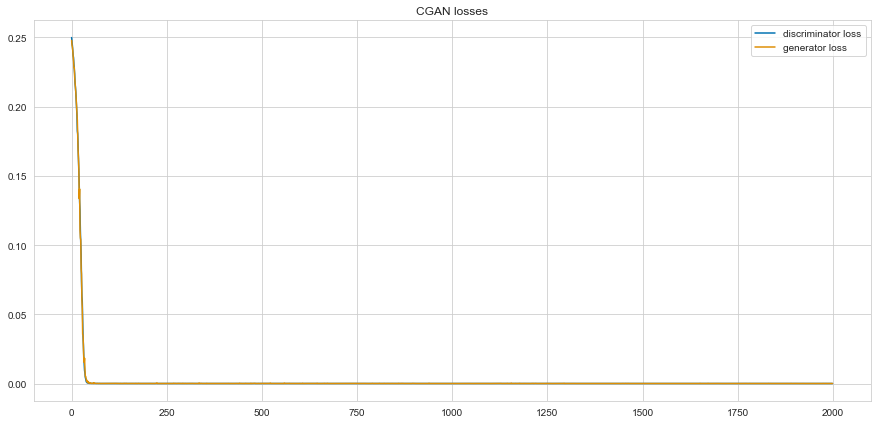

In [354]:
plt.figure(figsize=(15,7))
plt.plot([metrics[0] for metrics in d_metrics], label='discriminator loss')
plt.plot([metrics[0] for metrics in g_metrics], label='generator loss')
plt.legend()
plt.title('CGAN losses')
plt.show()

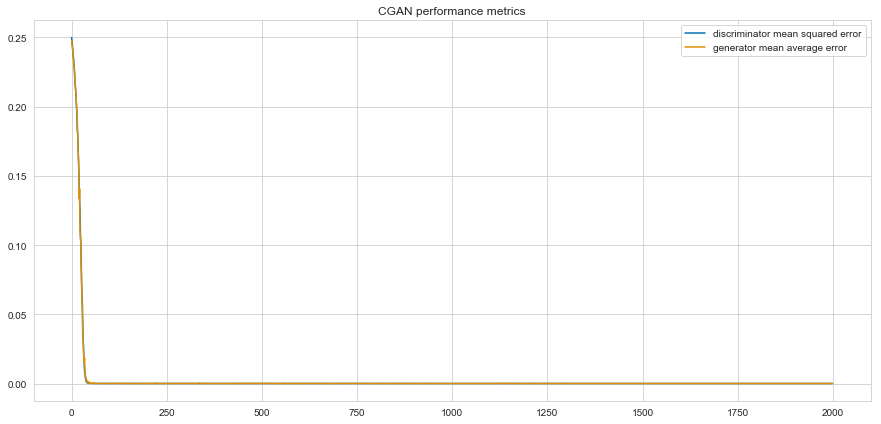

In [355]:
plt.figure(figsize=(15,7))
plt.plot([metrics[1] for metrics in d_metrics], label='discriminator mean squared error')
plt.plot([metrics[1] for metrics in g_metrics], label='generator mean average error')
plt.legend()
plt.title('CGAN performance metrics')
plt.show()

In [356]:
generated_y = generator.predict(np.random.rand(num_obs, gan_params['sequence_length'], gan_cols))[:,-1,-1]
gan_y = gan_df['label'].values

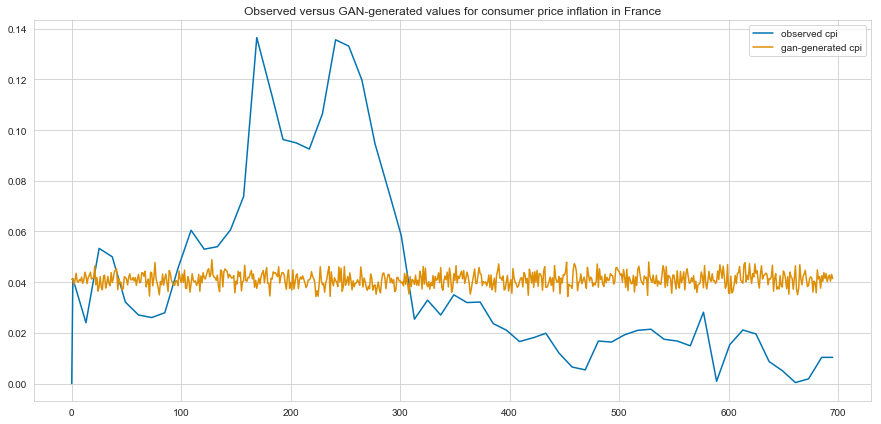

In [357]:
plt.figure(figsize=(15,7))
plt.plot(gan_y, label='observed cpi')
plt.plot(generated_y, label='gan-generated cpi')
plt.legend()
plt.title('Observed versus GAN-generated values for consumer price inflation in %s' % country)
plt.show()

In [358]:
print('rmse: %s\nmean observed: %s\nmean generated: %s' % (np.sqrt(mean_squared_error(gan_y, generated_y)),
                                                           np.mean(gan_y), np.mean(generated_y)))

rmse: 0.03693116439968972
mean observed: 0.04203555603346822
mean generated: 0.041025072
